В БЛОКНОТ

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import geopandas as gpd
tqdm.pandas()

stops_gdf = gpd.read_file("stopsLO.geojson")
stops_gdf.rename(columns={"Автоб": "route"}, inplace=True)
stops_gdf.dropna(subset="route", axis=0, inplace=True, how="any")
unique_routes = set()
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.add(i.lstrip().rstrip())
unique_routes = pd.DataFrame(index=list(unique_routes))
unique_routes["geometry"] = [[]] * len(unique_routes)
for index, row in (stops_gdf.iterrows()):
    for i in str(row["route"]).replace('.', ',').rstrip().lstrip().split(","):
        if i != "":
            unique_routes.loc[i.lstrip().rstrip(), "geometry"] = unique_routes.loc[i.lstrip().rstrip()]["geometry"] + [
                row["geometry"]]

unique_routes

,geometry
3,"[POINT (33.5536502 59.6433943), POINT (32.3536..."
590,"[POINT (31.4603405 59.8746524), POINT (31.5240..."
444,"[POINT (30.2052711 60.1438771), POINT (30.2061..."
135А,"[POINT (29.8153262 58.5633739), POINT (29.8157..."
34А,"[POINT (29.5123312 59.3544248), POINT (29.5115..."
...,...
487,"[POINT (30.1444949 59.7893016), POINT (30.1432..."
507,"[POINT (30.072354435427986 59.23605459126603),..."
301,"[POINT (30.2290361 59.7276999), POINT (30.2638..."
315А,"[POINT (30.7708032 59.5666144), POINT (30.7718..."


ПЕРЕНЕС

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from shapely import distance, Point


def clusterize(loc) -> pd.DataFrame:
    data = np.array([[p.x, p.y] for p in loc["geometry"]])
    noise = np.array(
        [[31.21239, 58.61124], [31.22239, 58.62161], [31.23239, 58.61171], [31.24239, 58.62129], [31.23239, 58.64131],
        [32.92133, 59.02899], [32.94933, 59.06599], [32.93943, 59.03599], [32.92733, 59.08999], [32.92333, 59.00599],
         [35.58878, 59.48945], [35.58933, 59.48359], [35.58643, 59.489759], [35.58879, 59.48688], [35.58869, 59.485749]])
    data = np.append(data, noise, axis=0)

    best_silhouette = -1
    best_labels = None
    k_values = range(2, 10 if len(data) > 10 else 2)

    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        labels = kmeans.labels_
        silhouette = silhouette_score(data, labels)
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_labels = labels

    data = data[:-15]
    if best_labels is not None:
        best_labels = best_labels[:-15]
    else:
        best_labels = [0 for _ in range(0, len(data))]
    # print("СИЛУЕТ:  "+str(best_silhouette))
    # if best_silhouette < 0.9:
    #     best_labels = [0 for _ in range(0, len(data))]
    data = pd.DataFrame({
        'label': best_labels,
        'geometry': [Point(p[0], p[1]) for p in data]
    })
    grouped_data = data.groupby('label')['geometry'].apply(list)
    grouped_data = pd.DataFrame(grouped_data).reset_index(drop=True)
    grouped_data.index = grouped_data.index + 1
    return grouped_data

В блокнот

In [4]:
from shapely import distance, Point

devided_routes = pd.DataFrame()
for index, row in tqdm(unique_routes.iterrows(), total=unique_routes.shape[0]):
    clusterized = clusterize(row)
    if clusterized.shape[0] > 1:
        clusterized.index = index + "." + clusterized.index.astype(str)
        devided_routes = pd.concat([devided_routes, clusterized])
    else:
        clusterized.index = [index]
        devided_routes = pd.concat([devided_routes, clusterized])
devided_routes

  0%|          | 0/592 [00:00<?, ?it/s]

,geometry
3.1,"[POINT (30.08645112859504 59.56957765642285), ..."
3.2,"[POINT (32.3536583 59.8943022), POINT (32.3623..."
3.3,"[POINT (28.5614882 59.3793053), POINT (28.5632..."
3.4,"[POINT (33.5536502 59.6433943), POINT (33.5477..."
3.5,"[POINT (29.847835 58.7284453), POINT (29.84985..."
...,...
487,"[POINT (30.1444949 59.7893016), POINT (30.1432..."
507,"[POINT (30.072354435427986 59.23605459126603),..."
301,"[POINT (30.2290361 59.7276999), POINT (30.2638..."
315А,"[POINT (30.7708032 59.5666144), POINT (30.7718..."


In [10]:
from shapely import MultiPoint
devided_routes['geometry']=devided_routes['geometry'].apply(lambda x:MultiPoint(x))
devided_routes = gpd.GeoDataFrame(devided_routes,geometry='geometry')

devided_routes.to_file("polina_file.geojson")

In [5]:
row = devided_routes.loc["8.5"]
city_crs = 32636
geometry_list = row["geometry"]
test_gdf = gpd.GeoDataFrame(data={"label": ["8.5" for _ in geometry_list], "geometry": geometry_list})
test_gdf = test_gdf.set_crs(4326)
test_gdf = test_gdf.to_crs(city_crs)
test_gdf = test_gdf.reset_index()
test_gdf


,index,label,geometry
0,0,8.5,POINT (316646.610 6514483.163)
1,1,8.5,POINT (317519.412 6514106.930)
2,2,8.5,POINT (317663.599 6514682.084)
3,3,8.5,POINT (317656.452 6515037.918)
4,4,8.5,POINT (317817.879 6515489.241)
5,5,8.5,POINT (317431.130 6514889.561)
6,6,8.5,POINT (317328.323 6514502.463)
7,7,8.5,POINT (317246.746 6514211.284)
8,8,8.5,POINT (317505.902 6515612.571)
9,9,8.5,POINT (316028.091 6515690.731)


project stops and create new graph

ПЕРЕНЕС

In [6]:
import networkx as nx
import osmnx as ox
from shapely import from_wkt, LineString, Point
import geopandas as gpd

nx_graph = nx.read_graphml("graph_for_test.graphml")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(nx_graph)
gdf_edges: gpd.GeoDataFrame = gdf_edges.reset_index()
gdf_buffer = gdf_edges.copy()
gdf_buffer["geometry"] = gdf_buffer["geometry"].apply(lambda x: LineString(x).buffer(-3, single_sided=True))
join = gpd.sjoin_nearest(test_gdf, gdf_buffer, distance_col="dist", how="inner")
join

,index,label,geometry,index_right,u,v,key,length_meter,type,time_min,dist
0,0,8.5,POINT (316646.610 6514483.163),370,63,42,0,200.473,car,0.71,3.806132
1,1,8.5,POINT (317519.412 6514106.930),32,2,150,0,236.390,car,0.83,4.829858
2,2,8.5,POINT (317663.599 6514682.084),202,19,4,0,184.469,car,0.65,3.319083
3,3,8.5,POINT (317656.452 6515037.918),234,314,8,0,112.972,car,0.40,14.377155
4,4,8.5,POINT (317817.879 6515489.241),87,18,22,0,372.057,car,1.31,1.010399
5,5,8.5,POINT (317431.130 6514889.561),64,5,219,0,131.615,car,0.46,5.770847
6,6,8.5,POINT (317328.323 6514502.463),70,219,149,0,614.199,car,2.17,8.316723
7,7,8.5,POINT (317246.746 6514211.284),926,149,1,0,232.238,car,0.82,8.156357
8,8,8.5,POINT (317505.902 6515612.571),219,21,274,0,177.763,car,0.63,25.440546
9,9,8.5,POINT (316028.091 6515690.731),256,26,360,0,362.026,car,1.28,4.566709


ПЕРЕНЕСЕНО

In [84]:
points = pd.DataFrame(data=None)
for index, row in join.iterrows():
    point: Point = row["geometry"]
    edges_to_delete, start, end = row[["index_right", "u", "v"]]
    line: LineString = gdf_edges.loc[edges_to_delete, "geometry"]
    nearest_point = line.interpolate(line.project(point))
    data = (str(edges_to_delete) + '_' + row["label"], start, end)
    points = pd.concat(
        [points, pd.DataFrame(
            {"edge": [data], "geometry": [nearest_point]})])
points = points.groupby('edge')['geometry'].apply(list).reset_index()
# points = gpd.GeoDataFrame(data=points,geometry="geometry",crs=city_crs)
# points.to_file("projected_normalized.geojson")
points

,edge,geometry
0,"(1033_8.5, 200, 357)",[POINT (316168.41619507485 6516288.538994102)]
1,"(1035_8.5, 200, 209)","[POINT (316192.2542079082 6516359.172764772), ..."
2,"(125_8.5, 12, 76)",[POINT (317360.4248681884 6517050.096409712)]
3,"(1_8.5, 0, 264)",[POINT (316914.7157165199 6514108.4316457575)]
4,"(202_8.5, 19, 4)",[POINT (317657.4653274753 6514683.602697591)]
5,"(219_8.5, 21, 274)",[POINT (317533.25234776846 6515604.773159838)]
6,"(225_8.5, 315, 21)",[POINT (317683.3525301027 6515710.593385909)]
7,"(234_8.5, 314, 8)",[POINT (317640.1687647791 6515043.985640216)]
8,"(244_8.5, 96, 75)",[POINT (316995.21702391224 6515411.257270565)]
9,"(256_8.5, 26, 360)",[POINT (316030.59804009995 6515697.870688187)]


ПЕРЕНЕСЕНО

In [85]:
from shapely import Point
from shapely.ops import split

new_graph: nx.MultiDiGraph = nx_graph.copy()
route_nodes = []
for _, row in points.iterrows():
    label, start, end = row["edge"]
    new_points = (row['geometry'].copy())
    postfix = 1
    current_edge = new_graph.get_edge_data(start, end)[0]['geometry']
    current_node = nx_graph.nodes[start]
    current_node = Point(current_node['x'], current_node['y'])
    length = len(new_points)

    while len(new_points) > 0:
        new_node = min(new_points, key=current_node.distance)

        new_node_name = label + (('_' + str(postfix)) if length > 1 else "")
        route_nodes.append((new_node_name, start, end))
        new_graph.add_node(new_node_name, x=new_node.x, y=new_node.y, desc="bus_stop")

        first, _, second = split(current_edge, new_node.buffer(0.0001)).geoms

        new_edge = LineString(list(first.coords[:-1]) + list(new_node.coords))
        new_graph.add_edge(start, new_node_name, length_meter=new_edge.length, geometry=new_edge)

        start = new_node_name
        current_edge = LineString(list(new_node.coords) + list(second.coords[1:]))
        current_node = new_node
        new_points.remove(new_node)
        postfix = postfix + 1

    new_graph.add_edge(new_node_name, end, length_meter=current_edge.length, geometry=current_edge)
route_nodes

[('1033_8.5', '200', '357'),
 ('1035_8.5_1', '200', '209'),
 ('1035_8.5_2', '1035_8.5_1', '209'),
 ('125_8.5', '12', '76'),
 ('1_8.5', '0', '264'),
 ('202_8.5', '19', '4'),
 ('219_8.5', '21', '274'),
 ('225_8.5', '315', '21'),
 ('234_8.5', '314', '8'),
 ('244_8.5', '96', '75'),
 ('256_8.5', '26', '360'),
 ('258_8.5', '357', '200'),
 ('259_8.5', '357', '26'),
 ('262_8.5', '360', '26'),
 ('284_8.5', '209', '101'),
 ('285_8.5', '209', '200'),
 ('2_8.5', '0', '41'),
 ('321_8.5', '38', '42'),
 ('324_8.5', '38', '39'),
 ('32_8.5', '2', '150'),
 ('369_8.5', '63', '59'),
 ('370_8.5', '63', '42'),
 ('467_8.5', '59', '94'),
 ('474_8.5', '94', '59'),
 ('527_8.5', '75', '96'),
 ('547_8.5', '101', '209'),
 ('64_8.5', '5', '219'),
 ('70_8.5', '219', '149'),
 ('714_8.5', '123', '190'),
 ('84_8.5', '274', '7'),
 ('872_8.5', '190', '123'),
 ('876_8.5', '126', '167'),
 ('87_8.5', '18', '22'),
 ('926_8.5', '149', '1')]

ПЕРЕНЕС

In [98]:
from src.dongraphio.utils.matrix_utils import get_nx2nk_idmap


def get_distance_matrixv2(graph: nx.DiGraph, nodes_from: [], nodes_to: [], path_matrix=False,
                          weight: str = 'length_meter') -> (
        pd.DataFrame, pd.DataFrame | None):
    
    mapping = get_nx2nk_idmap(graph)
    nk_graph = nk.nxadapter.nx2nk(graph, weight)
    
    distance_matrix = pd.DataFrame(0, index=nodes_from, columns=nodes_to).astype(object)
    if path_matrix:
        route_matrix = pd.DataFrame(index=nodes_from, columns=nodes_to)
    for source in tqdm(nodes_from, total=len(nodes_from), desc="Calculating distances"):
        for dest in nodes_to:
            biDij = nk.distance.BidirectionalDijkstra(nk_graph, mapping.get(source), mapping.get(dest), True).run()
            path = biDij.getPath()
            total_distance = biDij.getDistance()
            if path_matrix:
                route_matrix.loc[source, dest] = path
            distance_matrix.loc[source, dest] = total_distance
    if path_matrix:
        return distance_matrix, route_matrix
    return distance_matrix

ПЕРЕНЕС

In [99]:
subgraph = nx.DiGraph(new_graph)
route_nodes_ind = [x[0] for x in route_nodes]
distance_matrix, route_matrix = get_distance_matrixv2(subgraph, route_nodes_ind, route_nodes_ind, True)
max_value = distance_matrix.values.max()
for i in route_nodes:
    node_1, n1_1, n2_1 = i
    for j in route_nodes:
        node_2, n1_2, n2_2 = j
        if (n1_1, n2_1) == (n2_2, n1_2):
            distance_matrix.loc[node_1, node_2] = max_value
distance_matrix

Calculating distances:   0%|          | 0/34 [00:00<?, ?it/s]

,1033_8.5,1035_8.5_1,1035_8.5_2,125_8.5,1_8.5,202_8.5,219_8.5,225_8.5,234_8.5,244_8.5,...,527_8.5,547_8.5,64_8.5,70_8.5,714_8.5,84_8.5,872_8.5,876_8.5,87_8.5,926_8.5
1033_8.5,0.0,890.988563,1097.459787,2748.796569,3159.257121,4442.614221,5728.114631,5516.143247,4678.963813,1737.437252,...,1656.485529,2268.248187,4718.130492,5108.626668,1357.358651,5410.187875,1304.210594,1995.16595,5157.870345,3675.024304
1035_8.5_1,894.131322,0.0,206.471224,1858.725149,4000.308701,5283.665801,5078.778211,4823.396826,5520.015393,2578.488832,...,2497.537109,1378.176767,5559.182072,5949.678248,2250.621231,5114.792455,2197.473174,2836.21753,5517.499925,4516.075884
1035_8.5_2,687.660098,662.449919,0.0,1652.253925,3793.837477,5077.194577,4872.306987,4616.925603,5313.544169,2372.017608,...,2291.065885,1171.705543,5352.710848,5743.207025,2044.150008,4908.321231,1991.00195,2629.746307,5311.028701,4309.60466
125_8.5,1686.646668,1661.43649,1867.907713,0.0,3254.744047,4538.101148,4003.149557,3747.768173,4517.86074,1832.924178,...,1751.972455,512.000113,4557.027419,4957.144595,1869.650578,4039.163802,2063.308521,2090.652877,4441.871272,3770.51123
1_8.5,3427.878023,3402.667844,3609.139068,3722.39585,0.0,1284.058502,2569.558912,2357.587528,1520.408094,1868.692533,...,1893.04581,3445.784468,1559.574773,1950.070949,2029.656932,2251.632156,2223.314875,1540.697231,1999.314626,516.468585
202_8.5,4647.670116,4622.459937,4828.931161,4063.260943,1637.295495,0.0,1482.681005,1270.70962,433.530187,3088.484626,...,3112.837903,4574.528561,561.388866,682.676042,3249.449025,1164.754249,3443.106968,2760.489324,912.436719,984.204678
219_8.5,5194.295717,5169.085539,5375.556762,3521.184544,2183.921096,1468.135197,0.0,417.813222,791.527789,3635.110227,...,3659.463504,4032.452162,830.694467,1230.811644,3796.074627,37.93985,3989.732569,3307.114926,715.53832,1532.340279
225_8.5,5107.154971,5081.944792,5288.416016,3421.240798,2439.50335,1723.71745,255.92286,0.0,1047.110042,3890.692481,...,3915.045758,3932.508416,1086.276721,1486.393897,4051.65688,293.522104,4245.314823,3562.697179,971.120574,1787.922533
234_8.5,4933.333957,4908.123778,5114.595002,3629.950784,1922.959336,1207.173436,1049.370845,837.399461,0.0,3374.148467,...,3398.501744,4141.218402,569.732707,969.849883,3535.112866,731.44409,3728.770809,3046.153165,479.12656,1271.378519
244_8.5,1685.124569,1659.914391,1866.385614,1979.642396,1653.063948,2936.421049,4221.921458,4009.950074,3172.770641,0.0,...,6233.081008,1703.031014,3211.937319,3602.433496,286.903479,3903.994702,480.561421,488.972778,3651.677172,2168.831131


ПЕРЕНЕС

In [100]:

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def get_solution(manager, routing, solution) -> list[int]:
    result = []
    index = routing.Start(0)
    while not routing.IsEnd(index):
        result.append(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
    return result


dm = distance_matrix.values.tolist()
dm = [[round(num) for num in sublist] for sublist in dm]
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(dm), 1, 0)


def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return dm[from_node][to_node]


# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Define cost of each arc.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)

search_parameters.time_limit.seconds = 10

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

result = get_solution(manager, routing, solution)
mapping = dict(zip(range(distance_matrix.shape[0]), distance_matrix.index))
path = [mapping.get(i) for i in result]
path


['1033_8.5',
 '259_8.5',
 '256_8.5',
 '872_8.5',
 '527_8.5',
 '876_8.5',
 '474_8.5',
 '370_8.5',
 '324_8.5',
 '1_8.5',
 '32_8.5',
 '202_8.5',
 '234_8.5',
 '87_8.5',
 '225_8.5',
 '219_8.5',
 '84_8.5',
 '64_8.5',
 '70_8.5',
 '926_8.5',
 '2_8.5',
 '321_8.5',
 '369_8.5',
 '467_8.5',
 '244_8.5',
 '714_8.5',
 '262_8.5',
 '258_8.5',
 '1035_8.5_1',
 '1035_8.5_2',
 '284_8.5',
 '125_8.5',
 '547_8.5',
 '285_8.5']

НЕ НУЖНО

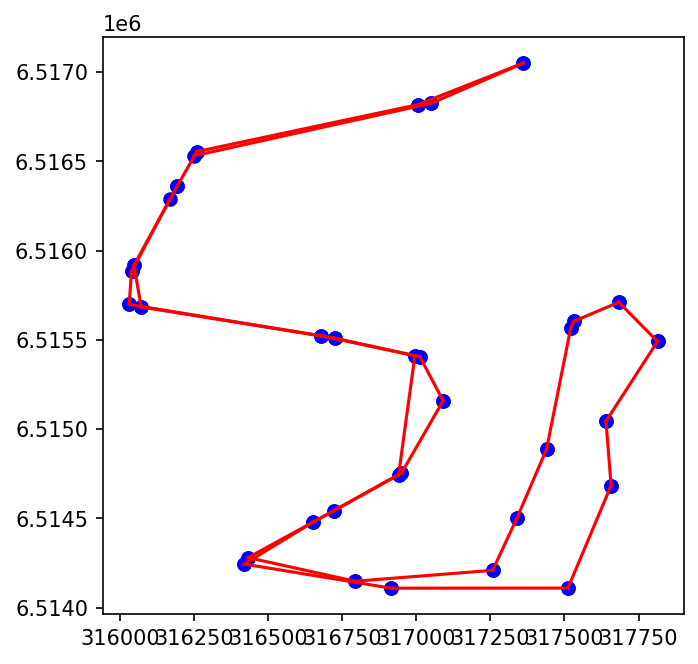

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=150)
for i in range(len(path) - 1):
    node1 = new_graph.nodes[path[i]]
    node2 = new_graph.nodes[path[i + 1]]
    plt.plot(*zip((node1['x'], node1['y']), (node2['x'], node2['y'])), color='red')
    plt.scatter([node1['x'], node2['x']], [node1['y'], node2['y']], color='blue')


НЕ НУЖНО

In [55]:
path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
full_route_nodes = []
for u, v in path_edges:
    route_ = route_matrix.loc[u, v]
    for node_ in route_[:-1]:
        full_route_nodes.append(node_)
df = pd.DataFrame()
for i in range(len(full_route_nodes) - 1):
    node1 = full_route_nodes[i]
    node2 = full_route_nodes[i + 1]
    geometry = new_graph[node1][node2]['geometry']
    temp_df = pd.DataFrame({'geometry': [geometry]})
    df = pd.concat([df, temp_df])
df = gpd.GeoDataFrame(data=df, geometry='geometry', crs=city_crs)
df.to_file("test_route.geojson")

Делаем граф автобусов

ПЕРЕНЕС

In [8]:
from shapely.ops import unary_union, transform

graph_from_points = nx.DiGraph()


def round_coordinates(x, y,):
    return round(x, 2), round(y, 2)

path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
path_edges.append((path[-1], path[0]))
route_number = str(path_edges[0][0]).split('_')[1].split('.')[0]
for u, v in path_edges:
    route_ = route_matrix.loc[u, v]
    new_route_geometry = None
    for i in range(len(route_) - 1):
        node1 = route_[i]
        node2 = route_[i + 1]
        cur_geom = transform(round_coordinates, LineString(subgraph[node1][node2]['geometry']))
        if new_route_geometry is None:
            new_route_geometry = cur_geom
        else:
            new_route_geometry = new_route_geometry.union(cur_geom)
    route_len = new_route_geometry.length
    graph_from_points.add_node(u, x=subgraph.nodes[u]['x'], y=subgraph.nodes[u]['y'], route=route_number)
    graph_from_points.add_node(v, x=subgraph.nodes[v]['x'], y=subgraph.nodes[v]['y'], route=route_number)
    graph_from_points.add_edge(u, v, geometry=new_route_geometry, route=route_number, length_meter=route_len)

for i in graph_from_points.edges(data=True):
    i[2]['geometry'] = str(i[2]['geometry'])
nx.write_graphml(graph_from_points, f"route_8.graphml")


KeyboardInterrupt: 

['1033_8.1',
 '259_8.1',
 '256_8.1',
 '872_8.1',
 '527_8.1',
 '876_8.1',
 '474_8.1',
 '370_8.1',
 '324_8.1',
 '1_8.1',
 '32_8.1',
 '202_8.1',
 '234_8.1',
 '87_8.1',
 '225_8.1',
 '219_8.1',
 '84_8.1',
 '64_8.1',
 '70_8.1',
 '926_8.1',
 '2_8.1',
 '321_8.1',
 '369_8.1',
 '467_8.1',
 '244_8.1',
 '714_8.1',
 '262_8.1',
 '258_8.1',
 '1035_8.1_1',
 '1035_8.1_2',
 '284_8.1',
 '125_8.1',
 '547_8.1',
 '285_8.1']

In [6]:
from shapely import from_wkt
from src.dongraphio.utils import get_osmnx_graph
import osmnx as ox
import networkx as nx

G_drive: nx.MultiDiGraph = get_osmnx_graph(
    2705630, 32636, "drive", truncate_by_edge=False
)
nx.write_graphml(G_drive, "graph_for_test.graphml")
for i in G_drive.edges(data=True):
    i[2]['geometry'] = from_wkt(str(i[2]['geometry']))
gdf = ox.graph_to_gdfs(G_drive, nodes=False)
gdf.to_file("graph_for_test.geojson")

2024-03-18 15:58:27.231 | DEBUG    | src.dongraphio.utils.graphs:get_osmnx_graph:58 - Extracting and preparing drive graph from OSM ...


ACO Алгорим ( муравьиной колонии), устаревший, застревает в локальных минумах в отличии от гугловского решателя.

In [ ]:
from dataclasses import dataclass
from math import sqrt
from math import inf
from numpy import exp
from random import random, shuffle, sample


class Base:
    """
    The base class for path finding algorithms.
    Contains common functions.
    """

    @staticmethod
    def _calculate_dist(dm: list[list[float]], indx: list[int]) -> float:
        """Calculates the path length based on the index list of the distance matrix."""

        dist = 0
        for i in range(len(indx) - 1):
            dist += dm[indx[i]][indx[i + 1]]
        return dist


@dataclass
class Path:
    """
    Dataclass describing a path using:
    * list of point indices;
    * path length;
    * path name (optional).
    """

    indx: list[int]
    leng: float
    name: str


class ACO(Base):
    """
    Ant Colony Optimization algorithm is introduced based on the foraging behavior of an ant
    for seeking a path between their colony and source food.\n
    -----
    `ants: int` THE NUMBER OF ANTS\n
    The total number of agents (ants) involved in one iteration.\n
    -----
    `iter: int` THE NUMBER OF ITERATIONS\n
    The maximum number of iterations of the algorithm.\n
    -----
    `a: float` INFORMATION ELICITATION FACTOR\n
    The information elicitation factor α, which represents the relative importance of the pheromone,
    reflects the importance of the accumulation of the pheromone with regard to the ants' path selection.\n
    -----
    `b: float` EXPECTED HEURISTIC FACTOR\n
    The expected heuristic factor β, which represents the relative importance of the visibility,
    reflects the importance of the heuristic information with regard to the ants' path selection.\n
    -----
    `p: float` PHEROMONE EVAPORATION COEFFICIENT\n
    The pheromone evaporation coefficient ρ, which represents the degree of pheromone evaporation,
    reflects the degree of mutual influence among ants. Generally, the value of  is [0, 1],
    which prevents the infinite accumulation of pheromone effectively.\n
    -----
    `q: float` PHEROMONE INTENSITY\n
    The pheromone intensity Q, which represents the total pheromone,
    affects the convergence speed of the alghoritm to a certain extent.\n
    """

    def __init__(self, ants: int, iter: int, a: float, b: float, p: float, q: float) -> None:
        """Initializes the hyperparameters for the algorithm."""

        self.ants = ants
        self.iter = iter
        self.a = a
        self.b = b
        self.p = p
        self.q = q

    @staticmethod
    def __select_i(selection: list[int]) -> int:
        """Selects a random index of the next 2D point."""

        sum_num = sum(selection)
        if sum_num == 0:
            return len(selection) - 1
        tmp_num = random()
        prob = 0
        for i in range(len(selection)):
            prob += selection[i] / sum_num
            if prob >= tmp_num:
                return i

    def __create_indx(self, dm: list[list[float]], pm: list[list[float]]) -> list[int]:
        """Creates a new ordering of 2D point indices based on the distance and pheromone."""

        l = len(dm)
        unvisited_indx = list(range(l))
        shuffle(unvisited_indx)
        visited_indx = [unvisited_indx.pop()]
        for _ in range(l - 1):
            i = visited_indx[-1]
            selection = []
            for j in unvisited_indx:
                selection.append(
                    (pm[i][j] ** self.a) * ((1 / max(dm[i][j], 10 ** -5)) ** self.b)
                )
            selected_i = ACO.__select_i(selection)
            visited_indx.append(unvisited_indx.pop(selected_i))
        visited_indx.append(visited_indx[0])
        return visited_indx

    def update_pm(self, pm: list[list[float]], tmp_indx: list[list[int]], tmp_leng: list[float]) -> None:
        """Updates the pheromone matrix."""

        l = len(pm)
        for i in range(l):
            for j in range(i, l):
                pm[i][j] *= 1 - self.p
                pm[j][i] *= 1 - self.p
        for i in range(self.ants):
            delta = self.q / tmp_leng[i]
            indx = tmp_indx[i]
            for j in range(l):
                pm[indx[j]][indx[j + 1]] += delta
                pm[indx[j + 1]][indx[j]] += delta

    def run(self, dm: list[list[float]], name: str = None, ) -> Path:
        """Runs the algorithm for the given 2D points."""
        l = len(dm)
        pm = [[1 for _ in range(l)] for _ in range(l)]

        res_indx = []
        res_leng = inf
        for _ in range(self.iter):
            tmp_indx = []
            tmp_leng = []
            for _ in range(self.ants):
                indx = self.__create_indx(dm, pm)
                tmp_indx.append(indx)
                tmp_leng.append(ACO._calculate_dist(dm, indx))
            self.update_pm(pm, tmp_indx, tmp_leng)
            best_leng = min(tmp_leng)
            if best_leng < res_leng:
                res_leng = best_leng
                res_indx = tmp_indx[tmp_leng.index(best_leng)]
        return Path(indx=res_indx, leng=res_leng, name=name)


In [ ]:
dm = distance_matrix.values.tolist()

aco = ACO(ants=150, iter=1500, a=1.1, b=0.8, p=0.2, q=10)

result = (aco.run(dm=distance_matrix.values.tolist(), name="ACO"))
mapping = dict(zip(range(distance_matrix.shape[0]), distance_matrix.index))
print(result.leng)
path = [mapping.get(i) for i in result.indx]
print(path)


РЕАЛИЗАЦИЯ "СОЕДИНЕНИЯ ОСТРОВОВ сабграфаГРАФА по исходному", не додумана и не реализована из за ненужности :(

In [ ]:
iter_ = 0
nonstop = list(nodes_to_save ^ set([i[0] for i in route_nodes]))
subgraph = nx.DiGraph(new_graph.subgraph(nonstop))
for i in subgraph.edges(data=True):
    i[2]['geometry'] = str(i[2]['geometry'])
nx.write_graphml(subgraph, "subgraph_0.graphml")
while len(list(nx.strongly_connected_components(subgraph))) > 1:
    min_dist = float("inf")
    min_path = []
    for component in list(nx.strongly_connected_components(subgraph)):
        for node in component:
            try:
                row = dist_matrix.loc[node].drop(node)
                min_dist_ = row.min()
                min_dist_column = row.idxmin()
                if min_dist_ < min_dist:
                    min_dist = min_dist_
                    min_path = path_nodes.loc[node][min_dist_column]
                    dist_matrix.loc[node, min_dist_column] = float("inf")
            except KeyError:
                pass
    for node in min_path:
        nonstop.append(node)
    iter_ = iter_ + 1
    print(iter_)
    subgraph = nx.DiGraph(new_graph.subgraph(nonstop))
    # for i in subgraph.edges(data=True):
    #     i[2]['geometry'] = str(i[2]['geometry'])
    # nx.write_graphml(subgraph,f"subgraph_{iter_}.graphml")

    print(min_dist)
    print(min_path)


НЕ НУЖНО, networkx нааамного медленее netrwokit

In [ ]:
import momepy
import pandas as pd
import networkx as nx
import networkit as nk
from shapely import distance, Point


def get_distance_matrix(graph: nx.DiGraph, nodes_from: [], nodes_to: [], path=False) -> (
        pd.DataFrame, pd.DataFrame | None):
    def heuristic(node1, node2):
        node1 = graph.nodes[node1]
        node2 = graph.nodes[node2]
        point1 = Point(node1['x'], node1['y'])
        point2 = Point(node2['x'], node2['y'])
        return distance(point1, point2)

    distance_matrix = pd.DataFrame(0, index=nodes_from, columns=nodes_to).astype(object)
    if path:
        route_matrix = pd.DataFrame(index=nodes_from, columns=nodes_to)
    for source in tqdm(nodes_from, total=len(nodes_from), desc="Calculating distances"):
        for dest in nodes_to:
            path = nx.astar_path(graph, source, dest, heuristic, weight='length_meter')
            total_distance = sum(graph[path[i]][path[i + 1]]['length_meter'] for i in range(len(path) - 1))
            if path:
                route_matrix.loc[source, dest] = path
            distance_matrix.loc[source, dest] = total_distance
    if path:
        return distance_matrix, route_matrix
    return distance_matrix